
#**TP2: Propiedades en Venta**



---


---


## *Facultad de Ingeniería, Universidad de Buenos Aires*

---
### *2do Cuatrimestre de 2022*

---
### *Organización de Datos*

### *Curso: Rodriguez*

---

## **Objetivo del trabajo**

---
---

Los conjuntos de datos a utilizar properati_argentina_2021 y properati_argentina_2021_decrip
se encuentran disponibles en el siguiente enlace, la descripción de las variables se encuentra
disponible aquí . Para este trabajo se plantean los siguientes objetivos generales:
- Procesamiento del Lenguaje Natural: el objetivo será analizar las descripciones de los avisos para construir nuevos features y reentrenar algunos modelos del TP1.
- Redes Neuronales: se deberán implementar dos modelos de red neuronal uno para
clasificación y otro para regresión.
- Ensamble de Modelos: el objetivo será construir dos ensambles híbridos uno para clasificación y otro para regresión pudiendo utilizar los modelos del TP1

---





## **Setup previo**


Importamos todas las librerías a utilizar a lo largo del trabajo.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn as sk
from sklearn import datasets
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import StandardScaler
from importlib import reload

Importamos el dataset original y lo guardamos para su posterior uso.

In [ ]:
dwn_url='https://drive.google.com/uc?id=1QOcQ3hOhzxadj34y_wcvwYNa0-fNrmn3'
ds_original = pd.read_csv(dwn_url)

Importamos el dataset que contiene las descripciones. Para ello previamente separamos el dataset en dos conjuntos donde uno contiene todas las filas del split train y otro del test.

In [ ]:
dwn_url_descrip_train='https://drive.google.com/uc?id=1d41f4YY2KC-rZ0DHR3izgB2jVaxyFs1r'
ds_descrip_train = pd.read_csv(dwn_url_descrip_train)

dwn_url_descrip_test='https://drive.google.com/uc?id=1L4zk4ektIEgeMMnhWXclzrHsK1o4EyKD'
ds_descrip_test = pd.read_csv(dwn_url_descrip_test)

In [ ]:
x_train = pd.read_csv('https://drive.google.com/uc?id=1sOpD9HgOjs6LzVEksLAX8-4AEbP4-wzh')
x_test = pd.read_csv('https://drive.google.com/uc?id=1S8sI6QdQalkiUJg8mT_dO00_TO_WvGKQ')

y_train = pd.read_csv('https://drive.google.com/uc?id=1r9yX8AecV66Ya2UJi4IbPB2JVo_gwT2S')
y_test = pd.read_csv('https://drive.google.com/uc?id=112e7sRozO0YRRjgdOJxEXfiVuhJ0xSvl')

In [ ]:
x_train_target = pd.read_csv('https://drive.google.com/uc?id=1xVlHoR4jXTNdOslM5W0Tvciz-qagN5x0')

x_test_target = pd.read_csv('https://drive.google.com/uc?id=1QgQmGjIwzMckA84GlNt26WmVoLbuHbwV')

In [ ]:
x_train_target=x_train_target.iloc[:,1:10]
x_test_target=x_test_target.iloc[:,1:10]

In [ ]:
# función auxiliar para mostrar gráficos completos 
def mostrar_metadata_grafico(titulo, ylabel=None, xlabel=None, leyendas=None):
  plt.title(titulo)
  if ylabel:
    plt.ylabel = ylabel
  if xlabel:
    plt.xlabel = xlabel
  if leyendas:
    plt.legend = leyendas
  plt.show()

Eliminamos la primer columna que hace referencia a los indices que tenia cuando se exporto el dataset. 


In [ ]:
y_train = y_train.property_price
y_test = y_test.property_price

x_train = x_train.iloc[:,1:20]
x_test = x_test.iloc[:,1:20]

ds_descrip_train = ds_descrip_train.iloc[:,1:3]
ds_descrip_test = ds_descrip_test.iloc[:,1:3]

Luego agregamos la columna descripción a los dataset train y test.

In [ ]:
x_train=pd.merge(x_train, ds_descrip_train, how='left', on='id')
x_test=pd.merge(x_test, ds_descrip_test, how='left', on='id')

## Ampliación del dataset

Utilizaremos la columna descripción para encontrar aspectos de una propiedad. Luego utilizaremos esos aspectos para crear nuevas columnas y ampliar el detaset original.

En principio, analizaremos las frases o valores repetidos.

Primero creamos un nuevo data frame para obtener la frecuencia de las palabras en cada una de las descripciones. Este dataframe se forma de manera tal que cada fila contiene cada palabra de las descripción correspondiente, conservando los valores de los demás features. 

In [ ]:
description_token_train = x_train[['property_description']]
description_token_test = x_test[['property_description']]

In [ ]:
description_token_train.property_description = description_token_train.property_description.str.split()
description_token_test.property_description = description_token_test.property_description.str.split()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
description_token_train = description_token_train.explode('property_description')
description_token_test = description_token_test.explode('property_description')

In [ ]:
description_token_train = description_token_train.reset_index()
description_token_test = description_token_test.reset_index()

Modificamos las palabras que presentan mayúsculas para que únicamente comiencen con letras minúsculas. 

In [ ]:
description_token_train['property_description'] = description_token_train['property_description'].str.lower()
description_token_test['property_description'] = description_token_test['property_description'].str.lower()

In [ ]:
description_token_train.rename(columns = {'property_description':'palabra', 'index':'indice'}, inplace = True)
description_token_test.rename(columns = {'property_description':'palabra', 'index':'indice'}, inplace = True)

Definimos una nueva función buscar_palabra para que se puedan buscar palabras (en el dataset que se pase por parametro) en una columna específica. 

In [ ]:
def buscar_palabra(ds=description_token_train,nombre=None):
  ds_palabra_buscada = ds[0:0]#creo el ds en estado vacio pero conservo las columnas
  for i in range(len(nombre)):
    con_coma_despues = nombre[i]+',' # concateno una coma

    ds_post_coma = ds[(ds['palabra'] == con_coma_despues)] # filtro por palabra buscada
    ds_aux = ds[(ds['palabra'] == nombre[i])]              # filtro por palabra buscada con coma 
    ds_palabra_buscada = pd.concat([ds_palabra_buscada, ds_aux, ds_post_coma])  #concateno ambos ds filtrados formando uno solo

  return ds_palabra_buscada

Definimos una nueva función mostrar_frecuencias para poder graficar las frecuencias de ciertas palabras en un dataset. 

In [ ]:
def mostrar_frecuencias(df, columna='palabra', ancho=25, alto=10):
    frecuencia_por_valor = df.groupby(columna).size().to_frame("frecuencia")
    frecuencia_por_valor = frecuencia_por_valor.sort_values(by="frecuencia", ascending=False).reset_index()
    frecuencia_por_valor.head(40).plot.bar(x=columna, y="frecuencia", figsize=(ancho, alto))
    mostrar_metadata_grafico(f"frecuencias de valores posibles de {columna}", ylabel="frecuencia", xlabel="valores posibles")

# Procesamiento del Lenguaje Natural

#### Análisis de frecuencias 

Agregamos ciertas palabras comunes presentes en las descripciones de cada propiedad. Dentro de este grupo se encuentran preposiciones, numeros, signos de puntación, entre otros.

In [ ]:
palabras_comunes = [',', '.','a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante', 'en', 'entre', 'hacia', 'hasta','mediante', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'versus', 'vía', 'y', 'el', 'o', 'la', 'del', 'al', 'que', 'un', 'las', 'los', 'se', 'una', 'son', 'es', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
'casa', 'departamento', 'ph', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete','1','1°','1er', '2', '2°', '2do','3', '3°', '3er','4', '4°', '4to','5', '5°', '5to','6', '6°', '6to','7', '7°', '7mo','8', '8°', '8vo',
'9', '9°', '9no','10', '10°', '10mo','11', '11°','primer','segundo', 'tercer', 'cuarto', 'quinto','sexto', 'septimo', 'octavo', 'noveno', 'decimo', '-', 'no', 'ambientes',
'muy', 'x', 'tu', '/', 'dormitorio', 'valor', 'esta', 'corredor', 'inmueble', 'edificio', 'responsable:', 'medidas', 'propiedad.', 'cuenta', 'excelente', '\n\n', '#',
 'm2', 'querés!', 'podés.', 'personas', 'encuentra', 'ley', 'dormitorios', 'id', 'comprá', '\n\n ', '<br>', 'accede', 'ser', 'su', 'propiedad', 'accedé', 'todos', 'metros',
  'venta', 'barrio', 'zona', 'lo', 'como', 'todo', 'tiene', 'puede', 'operación', 'operaciones','propietario', 'valores']

In [ ]:
barras_n = description_token_train[description_token_train['palabra'].map(description_token_train['palabra'].value_counts()) == 18119].palabra.values # palabras /n de diferentes tipos
frec_igual_a_uno = description_token_train[description_token_train['palabra'].map(description_token_train['palabra'].value_counts()) == 1].palabra.values

In [ ]:
ds_sin_palabras_comunes = description_token_train[~description_token_train.palabra.isin(palabras_comunes)]
ds_sin_palabras_comunes = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(barras_n)]
ds_sin_palabras_comunes = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(frec_igual_a_uno)]

Se analizará la frecuencia de las palabras en el dataset, evitando aquellas que son muy comunes en las descripciones de las propiedades.

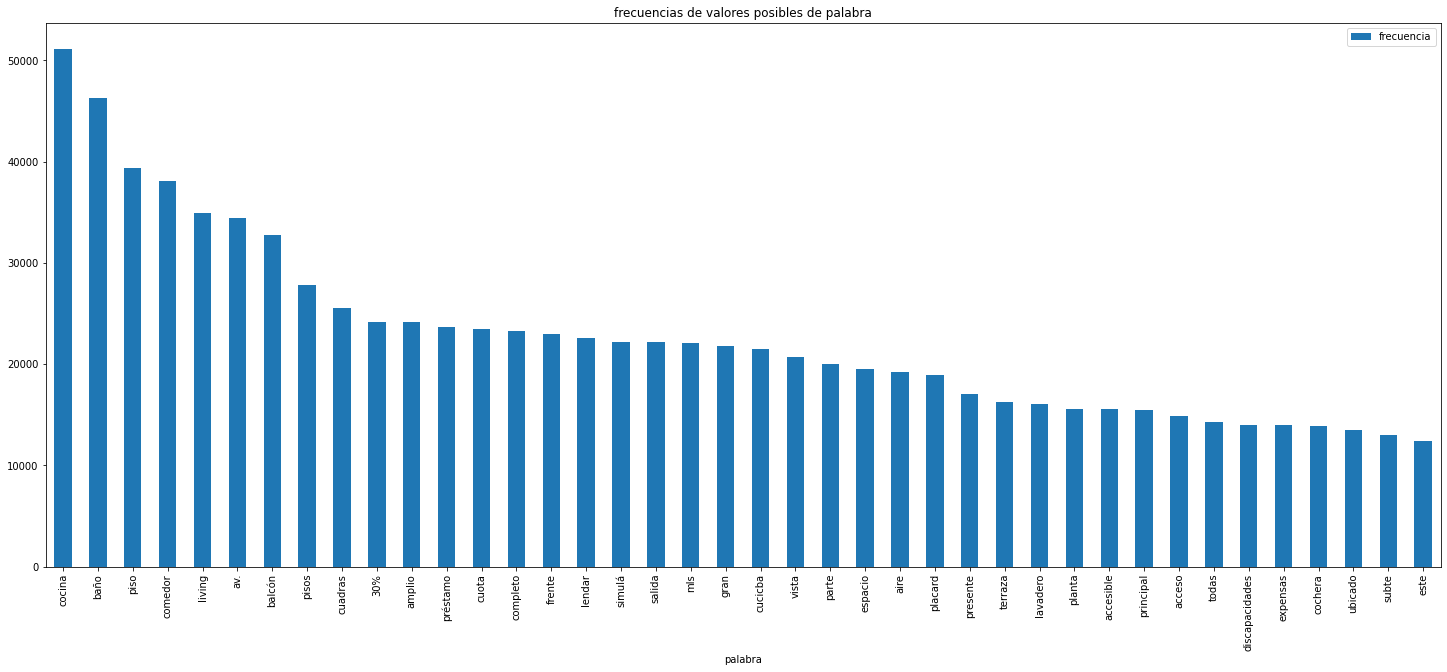

In [ ]:
mostrar_frecuencias(ds_sin_palabras_comunes)

Una vez analizada la frecuencia de las palabras anteriores, estudiaremos la frecuencia de las palabras que se encuentran dentro del mimso grupo en el grafico anterior pero que no parecen obvias para aparecer en la descripción de una propiedad.

In [ ]:
palabras_obvias = ['cocina', 'baño', 'piso', 'comedor', 'living', 'balcon', 'pisos', 'amplio', 'gran', 'vista', 'aire', 'terraza', 'metros', 'placard',
                   'lavadero','planta', 'patio', 'balcón', 'cochera']
ds_sin_palabras_obvias = ds_sin_palabras_comunes[~ds_sin_palabras_comunes.palabra.isin(palabras_obvias)]

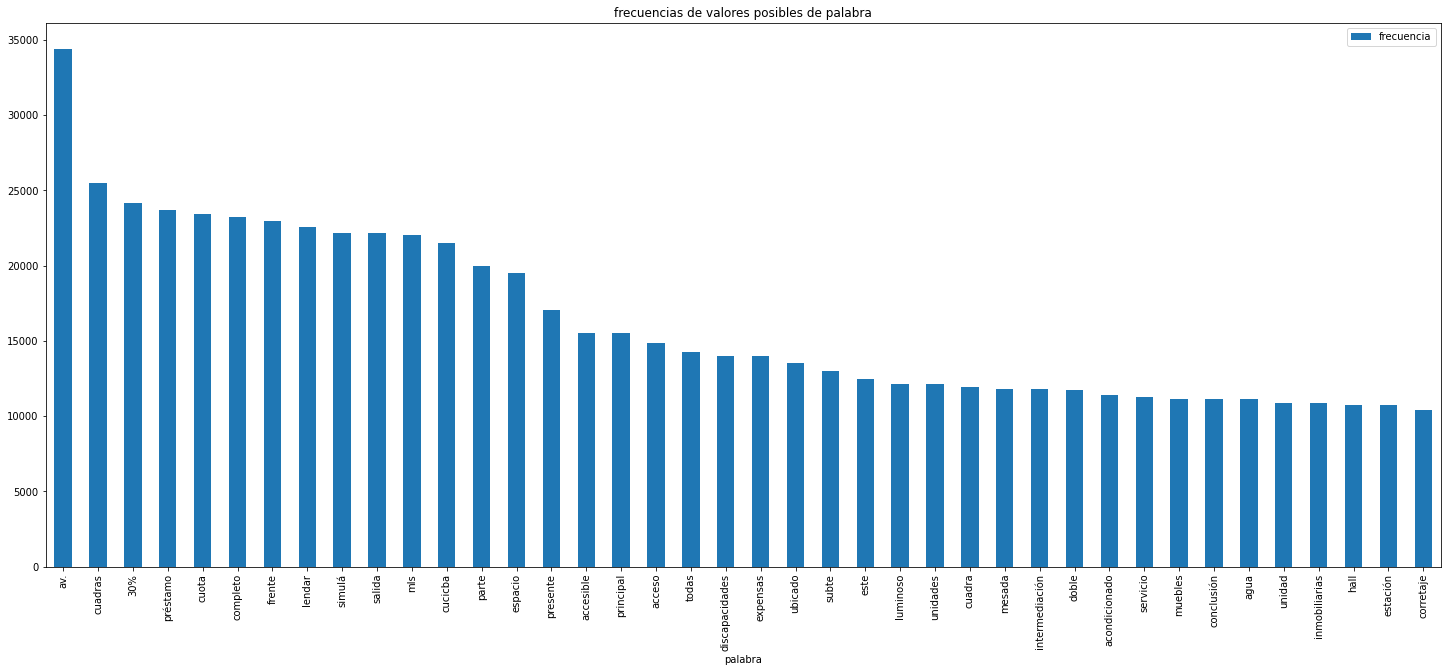

In [ ]:
mostrar_frecuencias(ds_sin_palabras_obvias)

Nos llamo la atencion que la palabra "simula" tiene una muy alta frecuencia, por lo tanto analizaremos sus palabras contiguas para entender la razón de su elevada frecuencia.

In [ ]:
ds_simula = buscar_palabra(nombre=['simulá'])
indices_simula = ds_simula.index

simula_mas_1=description_token_train.loc[indices_simula+1]
simula_mas_2=description_token_train.loc[indices_simula+2]
simula_mas_3=description_token_train.loc[indices_simula+3]
simula_mas_4=description_token_train.loc[indices_simula+4]

print(simula_mas_1.palabra.value_counts().head(3))
print('-------------------------------------------------')
print(simula_mas_2.palabra.value_counts().head(3))
print('-------------------------------------------------')
print(simula_mas_3.palabra.value_counts().head(3))
print('-------------------------------------------------')
print(simula_mas_4.palabra.value_counts().head(3))

tu    22192
Name: palabra, dtype: int64
-------------------------------------------------
cuota       22144
préstamo       27
crédito        12
Name: palabra, dtype: int64
-------------------------------------------------
en            22147
ingresando       25
\n\n              4
Name: palabra, dtype: int64
-------------------------------------------------
lendar        22095
a                25
lendartoda       16
Name: palabra, dtype: int64


Vemos que en la mayoria de los casos en los cual aparece la palabra "simulá" en una descripcion, termina formando la frase "Simulá tu cuota en Lendar".

#### Análisis de frecuencias de posibles features

Definimos los amenities que se pueden llegar a tener en un departamento para luego buscar estas palabras en el dataset original y crear un nuevo dataset de amenities.

In [ ]:
amenities = ['gym', 'gimnasio', 'spa', 'jacuzzi', 'pileta', 'piscina', 'alberca', 'solarium', 'sum', 'quincho', 'sauna', 'lavadero', 'baulera', 'atico', 'ático', 'altillo', 'sotano', 'sótano', 'parrilla', 'garage', 'cochera', 'estacionamiento']
ds_amenities = buscar_palabra(nombre=amenities)

Realizamos el mismo procedimiento con las palabras "terraza", "patio" y sus palabras relacionadas, creando un nuevo dataset de patio_balcon

In [ ]:
ds_patio_balcon = buscar_palabra(nombre=['terraza', 'patio', 'jardin', 'jardín', 'balcon', 'balcón'])

Detectamos la frecuancia de ciertos aspectos que se hayan en data frame e imprimimos la cantidad de veces que estos aparecen.

In [ ]:
ds_amenities.shape[0]

91338

In [ ]:
buscar_palabra(nombre=['luminoso','sol', 'luz', 'luminosidad', 'solar']).shape[0]

31632

In [ ]:
ds_patio_balcon.shape[0]

81916

In [ ]:
buscar_palabra(nombre=['expensas']).shape[0]

22157

In [ ]:
buscar_palabra(nombre=['seguridad','vigilancia', 'camaras', 'porteria', 'portería', 'camara', 'cámara', 'cámaras', 'alarma', 'prosegur', 'portero', 'encargado', 'guardia' ]).shape[0]

18387

In [ ]:
buscar_palabra(nombre=['amueblado','placard','armario','armarios','ropero','roperos','vestidor']).shape[0] 

28184

In [ ]:
buscar_palabra(nombre=['piso','pb']).shape[0] 

46426

In [ ]:
buscar_palabra(nombre=['nuevo','estrenar']).shape[0]

10309

In [ ]:
buscar_palabra(nombre=['metrobus','subte','colectivo','tren','estacion','estación']).shape[0] 

32365

#### Creación de Features 

In [ ]:
# ds_a_modificar es el dataset al que le agreamos el feature
def crear_nuevo_feature(ds_a_modificar,nombre_feature, ds, crear_de_cero = True, valor=None):
  if(crear_de_cero):
    ds_a_modificar[nombre_feature] = ds_a_modificar['property_currency'].values # Creamos un nuevo feature como copia de uno existente
    ds_a_modificar.loc[:, nombre_feature].replace(to_replace=["USD"],value=[valor],inplace=True) # Modificamos el valor, para inicializarlo en nulo o un valor determinado
  indices = ds['indice'].to_list() # Tomamos los indices reales y formamos una lista 
  for i in range(len(indices)):
    ds_a_modificar.at[indices[i], nombre_feature] = ds[ds['indice'] == indices[i]].palabra.values # Remplazamos el valor de la fila segun su indice

In [ ]:
def concatenar_ds(ds, ds_a_concatenar, combinaciones): 
  for i in range(len(combinaciones)):  
    ds_a_concatenar = pd.concat([ds_a_concatenar,ds[ ds.palabra == combinaciones[i] ]]) 
  return ds_a_concatenar

In [ ]:
def definir_numero_de_piso(ds_pisos, ds_pb, ds_plantas):  
  ds_pisos.loc[:,"palabra"].replace(to_replace=['1','1°', '1er', 'primer'],value=[1,1,1,1],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['2','2°', '2do', 'segundo'],value=[2,2,2,2],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['3','3°', '3er', 'tercer'],value=[3,3,3,3],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['4','4°', '4to', 'cuarto'],value=[4,4,4,4],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['5','5°', '5to', 'quinto'],value=[5,5,5,5],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['6','6°', '6to', 'sexto'],value=[6,6,6,6],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['7','7°', '7mo', 'septimo'],value=[7,7,7,7],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['8','8°', '8vo', 'octavo'],value=[8,8,8,8],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['9','9°', '9no', 'noveno'],value=[9,9,9,9],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['10','10°', '10mo', 'decimo'],value=[10,10,10,10],inplace=True)
  ds_pisos.loc[:,"palabra"].replace(to_replace=['11','11°'],value=[11,11],inplace=True)

  ds_pb.loc[:,"palabra"].replace(to_replace=['pb','pb,'],value=[0,0],inplace=True)
  ds_plantas.loc[:,"palabra"].replace(to_replace=['baja'],value=[0],inplace=True)
  
  return ds_pisos,ds_pb,ds_plantas

In [ ]:
def asignar_comuna(ds, barrios, valor): 
  for i in range(len(barrios)):
    ds.loc[:,"comuna"].replace(to_replace=[barrios[i]],value=[valor],inplace=True)

In [ ]:
def cambiar_valor_de_celda(ds, valor_viejo, nuevo_valor, es_string=True):
  for i in range(len(valor_viejo)):
    if(es_string):
      valor_seguido_de_coma = valor_viejo[i] + ','

    ds.loc[:,"palabra"].replace(to_replace=[valor_viejo[i]],value=[nuevo_valor],inplace=True)
    ds.loc[:,"palabra"].replace(to_replace=[valor_seguido_de_coma],value=[nuevo_valor],inplace=True)
  return ds  

In [ ]:
# Agrupa todas las palabras en una sola
def unificar_sinonimos_amenities(ds):
  ds = cambiar_valor_de_celda(ds,['piscina', 'alberca'],'pileta')
  ds = cambiar_valor_de_celda(ds,['gym'],'gimnasio')
  ds = cambiar_valor_de_celda(ds,['altillo','ático','atico'],'baulera')
  ds = cambiar_valor_de_celda(ds,['estacionamiento','garage'],'cochera')
  ds = cambiar_valor_de_celda(ds,['sótano'],'sotano')
  ds = cambiar_valor_de_celda(ds,['sum'],'quincho')
  return ds

In [ ]:
def obtener_sucesor_y_o_precesor_de_palabra(indices_palabra, ds = description_token_train, requiere_antes = True, requiere_despues = True):
  palabra_antes = ds.loc[indices_palabra-1]
  palabra_despues = ds.loc[indices_palabra+1]
  if((requiere_antes) and (not requiere_despues)): return palabra_antes
  if((not requiere_antes) and (requiere_despues)): return palabra_despues
  return palabra_antes, palabra_despues

##### Piso

###### Train

Buscamos que las palabras que le siguen a la palabra "planta" sean sí o sí "baja"

In [ ]:
ds_planta = buscar_palabra(nombre=['planta'])
indices_planta = ds_planta.index
planta_despues = description_token_train.loc[indices_planta+1]

In [ ]:
ds_planta_baja = planta_despues[0:0]
ds_planta_baja = concatenar_ds(planta_despues, ds_planta_baja, ['baja'])
ds_planta_baja = ds_planta_baja[~ds_planta_baja.duplicated(subset='indice',keep='first')]

In [ ]:
ds_pb = buscar_palabra(nombre=['pb'])

Eliminamos las filas que tienen indice duplicado conservando una muestra de ellas.

In [ ]:
ds_pb=ds_pb[~ds_pb.duplicated(subset='indice',keep='first')]

Procedemos a realizar un analisis de las palabras que se encuentran antes y despues de cada palabra buscada, en este caso piso.

In [ ]:
ds_piso = buscar_palabra(nombre=['piso'])
indices_piso = ds_piso.index

piso_antes=description_token_train.loc[indices_piso-1]
piso_despues=description_token_train.loc[indices_piso+1]

Debido a que tenemos un data frame que en cada fila contiene una palabra y respeta el orden en el que cada una de estas se encuentra en la descripción, tomamos las palabras que estan justo antes y después de la palabra a analizar para verificar que la interpretación de la misma sea la buscada.

In [ ]:
combinaciones_posibles_pre_piso=['1','1°','1er', '2', '2°', '2do','3', '3°', '3er','4', '4°', '4to','5', '5°', '5to','6', '6°', '6to','7', '7°', '7mo','8', '8°', '8vo',
     '9', '9°', '9no','10', '10°', '10mo','11', '11°','primer','segundo', 'tercer', 'cuarto', 'quinto','sexto', 'septimo', 'octavo', 'noveno', 'decimo' ]
ds_pisos = piso_antes[0:0]
ds_pisos = concatenar_ds(piso_antes, ds_pisos, combinaciones_posibles_pre_piso)

combinaciones_posibles_post_piso=['1','1°', '2', '2°','3', '3°','4', '4°','5', '5°','6', '6°','7', '7°','8', '8°','9', '9°','10', '10°','11', '11°']
ds_pisos = concatenar_ds(piso_despues, ds_pisos, combinaciones_posibles_post_piso)

Buscamos la cantidad de filas con un mismo índice.

In [ ]:
print(f"Cantidad de filas con un mismo indice: {ds_pisos[ds_pisos.duplicated(subset='indice')].shape[0]}")

Cantidad de filas con un mismo indice: 1927


Luego eliminamos las filas que contienen un mismo índice y conservamos una única muestra.

In [ ]:
ds_pisos.drop(ds_pisos[ds_pisos.duplicated(subset='indice')].index, inplace=True)

Reemplazamos todas las palabras relacionadas a un determinado número que hagan referencia a lo mismo. 

In [ ]:
ds_pisos,ds_pb,ds_planta_baja = definir_numero_de_piso(ds_pisos,ds_pb,ds_planta_baja)

Tomamos una columna del dataset para crear una nueva con el mismo tamaño y la inicializamos con valor nulo.

In [ ]:
crear_nuevo_feature(x_train,'piso', ds_pisos, valor=-1)

Agregamos los valores del feature piso teniendo en cuenta el índice tanto para los pisos que ya tienen un número asignado como para los pisos que tienen asignado PB, en este caso se le va a agregar un valor de piso 0. 

In [ ]:
crear_nuevo_feature(x_train, 'piso', ds_pb, crear_de_cero=False)
crear_nuevo_feature(x_train, 'piso', ds_planta_baja, crear_de_cero=False)

Asignamos como piso 0 a todas las casas y phs existentes en el dataset de train.

In [ ]:
x_train[x_train.property_type=='Casa'] = x_train[x_train.property_type=='Casa'].assign(piso=0) 
x_train[x_train.property_type=='PH'] = x_train[x_train.property_type=='PH'].assign(piso=0) 

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_piso = x_train[x_train.piso == -1].piso.shape[0]
con_piso = 100 - (sin_piso/x_train.shape[0]*100)
print("El porcentaje de valores válidos en la nueva variable piso es de:",con_piso)

El porcentaje de valores válidos en la nueva variable piso es de: 36.430634241797776


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

###### Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_planta_test = buscar_palabra(description_token_test,nombre=['planta'])
indices_planta_test = ds_planta_test.index
planta_despues_test=description_token_test.loc[indices_planta_test+1]

In [ ]:
ds_planta_baja_test = planta_despues_test[0:0]
ds_planta_baja_test = concatenar_ds(planta_despues_test, ds_planta_baja, ['baja'])

In [ ]:
ds_planta_baja_test=ds_planta_baja_test[~ds_planta_baja_test.duplicated(subset='indice',keep='first')]

In [ ]:
ds_pb_test = buscar_palabra(description_token_test, nombre=['pb'])

Eliminamos los que tienen indice duplicado conservando una muestra de ellos.

In [ ]:
ds_pb_test=ds_pb_test[~ds_pb_test.duplicated(subset='indice',keep='first')]

Procedemos a realizar un analisis de las palabras que se encuentran antes y despues de cada palabra buscada, en este caso piso.

In [ ]:
ds_piso_test = buscar_palabra(description_token_test,nombre=['piso'])
indices_piso = ds_piso_test.index

piso_antes_test=description_token_test.loc[indices_piso-1]
piso_despues_test=description_token_test.loc[indices_piso+1]

Debido a que tenemos un data frame que en cada fila contiene una palabra y respeta el orden en el que cada una de estas se encuentra en la descripción, tomamos las palabras que estan justo antes y después de la palabra a analizar para verificar que la interpretación de la misma sea la buscada.

In [ ]:
ds_pisos_test = piso_antes_test[0:0]
ds_pisos_test = concatenar_ds(piso_antes_test, ds_pisos_test, combinaciones_posibles_pre_piso) #con palabras antes
ds_pisos_test = concatenar_ds(piso_despues_test, ds_pisos_test, combinaciones_posibles_post_piso) #con palabras despues 

In [ ]:
ds_pisos_test.drop(ds_pisos_test[ds_pisos_test.duplicated(subset='indice')].index, inplace=True)

In [ ]:
ds_pisos_test,ds_pb_test,ds_planta_baja_test = definir_numero_de_piso(ds_pisos_test,ds_pb_test,ds_planta_baja_test)

In [ ]:
crear_nuevo_feature(x_test,'piso', ds_pisos_test, valor=-1)
crear_nuevo_feature(x_test,'piso', ds_pb_test, crear_de_cero=False)

Asignamos como piso 0 a todas las casas y phs existentes en el dataset de test.

In [ ]:
x_test[x_test.property_type=='Casa'] = x_test[x_test.property_type=='Casa'].assign(piso=0) 
x_test[x_test.property_type=='PH'] = x_test[x_test.property_type=='PH'].assign(piso=0) 

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_piso_test= x_test[x_test.piso == -1].piso.shape[0]
con_piso_test = 100 - (sin_piso_test/x_test.shape[0]*100)
print("El porcentaje de valores validos en la nueva variable piso es de:",con_piso_test)

El porcentaje de valores validos en la nueva variable piso es de: 33.05371596762325


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

##### Amenities

###### Train

Buscamos la cantidad de amenities total que tiene cada propiedad, para ello filtramos por indice en el dataset ds_amenities.

In [ ]:
ds_amenities['indice'].value_counts()

50511    24
41189    24
51704    23
39128    23
61225    22
         ..
43719     1
43723     1
43726     1
43729     1
54356     1
Name: indice, Length: 37980, dtype: int64

Reemplazamos las palabras que son sinónimos entre sí. 

In [ ]:
ds_amenities = unificar_sinonimos_amenities(ds_amenities)

Podemos obtener la cantidad total de amenities que tiene cada propiedad, sin duplicados. Para ello eliminamos las filas que tienen un mismo indice y palabras duplicadas y luego filtramos por indice en el dataset ds_amenities.

In [ ]:
print("Cantidad de filas con mismo índice y palabra:", ds_amenities[ds_amenities.duplicated(subset=['indice','palabra'])].shape[0])

Cantidad de filas con mismo índice y palabra: 9816


In [ ]:
ds_amenities.drop(ds_amenities[ds_amenities.duplicated(subset=['indice','palabra'])].index, inplace=True)
cant_amenities = ds_amenities['indice'].value_counts().values

Eliminamos todas las filas que tienen el mismo indice, quedandonos con solo una fila por indice, es decir que va a conservar solo un amenitie. Esto es para luego asignar en su lugar la cantidad de amenities correspondientes a cada indice.

In [ ]:
ds_amenities.drop(ds_amenities[ds_amenities.duplicated(subset=['indice'])].index, inplace=True)
ds_amenities.palabra = cant_amenities

Finalmente, procedemos a crear el nuevo feature "amenities" en el dataset de train.

In [ ]:
crear_nuevo_feature(x_train,'amenities', ds_amenities, valor=0)

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
sin_amenities = x_train[x_train.amenities == 0].amenities.shape[0]
con_amenities = 100 - (sin_amenities/x_train.shape[0]*100)
print("El porcentaje de valores con amenities es de:",con_amenities)

El porcentaje de valores con amenities es de: 59.936560039137085


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_amenities_test = buscar_palabra(description_token_test,nombre=amenities)

Reemplazamos las palabras que son sinónimos entre sí. 

In [ ]:
ds_amenities_test = unificar_sinonimos_amenities(ds_amenities_test)

In [ ]:
ds_amenities_test.drop(ds_amenities_test[ds_amenities_test.duplicated(subset=['indice','palabra'])].index, inplace=True)

In [ ]:
cant_amenities_test = ds_amenities_test['indice'].value_counts().values

In [ ]:
ds_amenities_test.drop(ds_amenities_test[ds_amenities_test.duplicated(subset=['indice'])].index, inplace=True)

In [ ]:
ds_amenities_test.palabra = cant_amenities_test

Observamos el porcentaje de valores válidos para el nuevo feature creado.

In [ ]:
crear_nuevo_feature(x_test,'amenities', ds_amenities_test, valor=0)

In [ ]:
sin_amenities = x_test[x_test.amenities == 0].amenities.shape[0]
con_amenities = 100 - (sin_amenities/x_test.shape[0]*100)
print("El porcentaje de valores con amenities es de:",con_amenities)

El porcentaje de valores con amenities es de: 59.84179543782193


##### Patio/Balcón

######Train

Podemos ver que se tiene mas de una fila por cada índice.

In [ ]:
print("Cantidad de filas con mismo índice:", ds_patio_balcon[ds_patio_balcon.duplicated(subset=['indice'])].shape[0])

Cantidad de filas con mismo índice: 39481


Eliminamos todas las filas que tienen el mismo indice, quedandonos con solo una fila por indice.

In [ ]:
ds_patio_balcon.drop(ds_patio_balcon[ds_patio_balcon.duplicated(subset=['indice'])].index, inplace=True)
ds_patio_balcon['indice'].value_counts()

3        1
11573    1
11578    1
11580    1
11581    1
        ..
11737    1
11759    1
11765    1
11773    1
63320    1
Name: indice, Length: 42435, dtype: int64

Como tenemos que hacer un feature booleano, tomamos la cantidad de veces que se repite el índice sabiendo que será 0 o 1, y de esta forma tenemos la afirmación o negación del booleano, respectivamente. 

In [ ]:
tiene_patio_o_balcon = ds_patio_balcon['indice'].value_counts().values

In [ ]:
ds_patio_balcon.palabra = tiene_patio_o_balcon

Agregamos los valores 0 y 1 para el caso de si una propiedad tiene patio o balcón. 0 para el caso negativo y 1 para el caso positivo.

In [ ]:
crear_nuevo_feature(x_train,'tiene_patio_o_balcon', ds_patio_balcon, valor=0)

In [ ]:
sin_patio_o_balcon= x_train[x_train.tiene_patio_o_balcon == 0].tiene_patio_o_balcon.shape[0]
con_patio_o_balcon= 100 - (sin_patio_o_balcon/x_train.shape[0]*100)
print("El porcentaje de valores con patio o balcon es de:",con_patio_o_balcon)

El porcentaje de valores con patio o balcon es de: 66.96703331386999


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible.

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_patio_balcon_test = buscar_palabra(description_token_test,nombre=['terraza','patio','jardin', 'jardín', 'balcon','balcón'])

In [ ]:
ds_patio_balcon_test.drop(ds_patio_balcon_test[ds_patio_balcon_test.duplicated(subset=['indice'])].index, inplace=True)

In [ ]:
tiene_patio_o_balcon_test = ds_patio_balcon_test['indice'].value_counts().values

In [ ]:
ds_patio_balcon_test.palabra = tiene_patio_o_balcon_test

Agregamos los valores 0 y 1 para el caso de si una propiedad tiene patio o balcón. 0 para el caso negativo y 1 para el caso positivo.

In [ ]:
crear_nuevo_feature(x_test,'tiene_patio_o_balcon', ds_patio_balcon_test, valor=0)

In [ ]:
sin_patio_o_balcon_test= x_test[x_test.tiene_patio_o_balcon== 0].tiene_patio_o_balcon.shape[0]
con_patio_o_balcon_test= 100 - (sin_patio_o_balcon_test/x_test.shape[0]*100)
print("El porcentaje de valores con patio o balcon es de:",con_patio_o_balcon_test)

El porcentaje de valores con patio o balcon es de: 67.1596762325239


#####Avenidas

######Train

En base al analisis de la frecuencia hecho anteriormente, detectamos que la palabra "av." y "avenida" tenian una alta frecuencia, por lo tanto realizamos un análisis de si es posible crear un feature en el cual se indique si la propiedad se encuentra sobre una avenida o no.

In [ ]:
ds_av = buscar_palabra(nombre=['av.', 'avenida'])
indices_av = ds_av.index

av_antes = description_token_train.loc[indices_av-1] #obtiene las palabras que estan antes de la palabra av. o avenida 
av_despues = description_token_train.loc[indices_av+1] #obtiene las palabras que estan despues de la palabra av. o avenida 

Analizamos cual es el porcentaje, respecto del total de veces que aparece la palabra avenida, de la cantidad de veces que precede la palabra "de" a "av." o "avenida", teniendo en cuenta que si se forman las frases "de av." o "de avenida" muy probablemente se este haciendo referencia a una propiedad que se encuentra en las cercanías de una avenida en particular. 

In [ ]:
av_antes.palabra.value_counts()

de                          19659
la                           8488
y                            3088
sobre                        2275
a                             975
                            ...  
(metrobús                       1
vélez,                          1
cañitas<br><br><br>sobre        1
574.-<br><br>entre              1
salvador).<br><br>sobre         1
Name: palabra, Length: 1322, dtype: int64

Buscamos las palabras anteriores a LA en donde despues de LA va "avenida" o "av."

In [ ]:
palabra_LA_indices = av_antes[av_antes.palabra == 'la'].index
palabra_LA_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(palabra_LA_indices, requiere_despues = False)
palabra_LA_antes_de_avenida.palabra.value_counts()

de                         5031
sobre                      1357
a                           471
y                           291
en                          270
                           ... 
categoría!<br><br>sobre       1
lópez,                        1
esta                          1
o                             1
ríos,                         1
Name: palabra, Length: 211, dtype: int64

Buscamos las palabras anteriores a DE en donde despues de DE va "la avenida" o "la av."

In [ ]:
palabra_DE_antes_de_la_avenida_indices = av_antes[av_antes.palabra == 'de'].index
palabra_DE_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(palabra_DE_antes_de_la_avenida_indices, requiere_despues = False)
palabra_DE_antes_de_la_avenida.palabra.value_counts()

cuadras            7226
cuadra             4311
metros             2915
mts                 625
y                   340
                   ... 
70mts                 1
8300                  1
equina                1
medio                 1
aproximadamente       1
Name: palabra, Length: 383, dtype: int64

Concluimos en que cuando la palabra "la" precede a "avenida" o "av." hace referencia a que la propiedad que hace referencia a tal descripción esta cerca de la avenida mencionada. Teniendo en cuenta las palabras que preceden a "de la avenida" o "de av.", encontramos todas medidas de longitud, como por ejemplo cuadras, metros, etc. 

In [ ]:
palabra_1 = "'de av.'"
palabra_2 = "'de avenida'"

de_indices = av_antes[av_antes.palabra == 'de'].index
palabra_DE_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(de_indices, requiere_despues = False)

print(f'El porcentaje de veces que figura la palabra {palabra_1} o {palabra_2} respecto del total es: ',palabra_DE_antes_de_avenida.shape[0]/av_antes.palabra.shape[0]*100)

El porcentaje de veces que figura la palabra 'de av.' o 'de avenida' respecto del total es:  43.99659825884565


Vemos que la frase 'de av.' o 'de avenida' es la mas frecuente, ocupando casi un 50% de todos los casos.

En general, se puede decir que cuando se tiene la frase "de la avenida" o "de avenida", la misma indica que la propiedad se encuentra en las cercanias de una avenida ya que la palabra precesora a cualquiera de las dos frases esta relacionada a medidas de longitud como pueden ser las cuadras, metros, entre otras. 

Tomamos la decision de armar un feature el cual indique si la propiedad esta cerca o no de una avenida. Para ello, tomamos de las descripciones las palabras que preceden a la palabra "avenida" y sean alguna de las siguientes: "de", "sobre", "en", "y", "la".

Para el caso de la palabra "la", tomaremos las descripciones que cumplan con 
la condicion de que antes de la misma se tenga como predecesores a las palabras "de", "sobre", "en", "y". 

In [ ]:
# Tanto la frase "de avenida" como "la avenida" ya las tenemos

sobre_indices = av_antes[av_antes.palabra == 'sobre'].index
palabra_SOBRE_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices, requiere_despues = False)

en_indices = av_antes[av_antes.palabra == 'en'].index
palabra_EN_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(en_indices, requiere_despues = False)

y_indices = av_antes[av_antes.palabra == 'y'].index
palabra_Y_antes_de_avenida = obtener_sucesor_y_o_precesor_de_palabra(y_indices, requiere_despues = False)

In [ ]:
# La frase "de la avenida" ya lo tenemos

sobre_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'sobre'].index
palabra_SOBRE_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices, requiere_despues = False)

en_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'en'].index
palabra_EN_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(en_indices, requiere_despues = False)

y_indices = palabra_LA_antes_de_avenida[palabra_LA_antes_de_avenida.palabra == 'y'].index
palabra_Y_antes_de_la_avenida = obtener_sucesor_y_o_precesor_de_palabra(y_indices, requiere_despues = False)

In [ ]:
ds_a_concatenar = ds_av[0:0]
ds_a_concatenar = pd.concat([ds_a_concatenar,palabra_DE_antes_de_avenida, palabra_DE_antes_de_la_avenida, palabra_EN_antes_de_avenida, palabra_EN_antes_de_la_avenida, palabra_SOBRE_antes_de_avenida, palabra_SOBRE_antes_de_la_avenida, palabra_Y_antes_de_avenida, palabra_Y_antes_de_la_avenida ])

Eliminamos todas las filas con índice duplicado quedandonos con una unica muestra. 

In [ ]:
ds_a_concatenar = ds_a_concatenar.drop_duplicates(subset='indice')

Una vez que tenemos solo una unica muestra, procedemos a crear el feature "esta_cerca_de_av".

In [ ]:
esta_cerca_de_av = ds_a_concatenar['indice'].value_counts().values

In [ ]:
ds_a_concatenar.palabra = esta_cerca_de_av

In [ ]:
crear_nuevo_feature(x_train,"esta_cerca_de_av", ds_a_concatenar, crear_de_cero = True, valor=0)

In [ ]:
lejos_de_av= x_train[x_train.esta_cerca_de_av== 0].esta_cerca_de_av.shape[0]
cerca_de_av= 100 - (lejos_de_av/x_train.shape[0]*100)
print("El porcentaje de propiedades que estan cerca de una avenida es de:",cerca_de_av)

El porcentaje de propiedades que estan cerca de una avenida es de: 28.787854877144255


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
ds_av_test = buscar_palabra(description_token_test,nombre=['av.', 'avenida'])
indices_av_test = ds_av_test.index

av_antes_test = description_token_test.loc[indices_av_test-1] #obtiene las palabras que estan antes de la palabra av. o avenida 
av_despues_test = description_token_test.loc[indices_av_test+1] #obtiene las palabras que estan despues de la palabra av. o avenida 

In [ ]:
DE_indices_test = av_antes_test[av_antes_test.palabra == 'de'].index
palabra_DE_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(DE_indices_test, requiere_despues = False, ds = description_token_test)

LA_indices_test = av_antes_test[av_antes_test.palabra == 'la'].index
palabra_LA_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(LA_indices_test, requiere_despues = False, ds = description_token_test)

sobre_indices_test = av_antes_test[av_antes_test.palabra == 'sobre'].index
palabra_SOBRE_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices_test, requiere_despues = False, ds = description_token_test)

en_indices_test = av_antes_test[av_antes_test.palabra == 'en'].index
palabra_EN_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(en_indices_test, requiere_despues = False, ds = description_token_test)

y_indices_test = av_antes_test[av_antes_test.palabra == 'y'].index
palabra_Y_antes_de_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(y_indices_test, requiere_despues = False, ds = description_token_test)

In [ ]:
DE_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'de'].index
palabra_DE_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(DE_indices_test, requiere_despues = False, ds = description_token_test)

sobre_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'sobre'].index
palabra_SOBRE_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(sobre_indices_test, requiere_despues = False, ds = description_token_test)

en_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'en'].index
palabra_EN_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(en_indices_test, requiere_despues = False, ds = description_token_test)

y_indices_test = palabra_LA_antes_de_avenida_test[palabra_LA_antes_de_avenida_test.palabra == 'y'].index
palabra_Y_antes_de_la_avenida_test = obtener_sucesor_y_o_precesor_de_palabra(y_indices_test, requiere_despues = False, ds = description_token_test)

In [ ]:
ds_a_concatenar_test = ds_av[0:0]
ds_a_concatenar_test = pd.concat([ds_a_concatenar_test,palabra_DE_antes_de_avenida_test, palabra_DE_antes_de_la_avenida_test, palabra_EN_antes_de_avenida_test, palabra_EN_antes_de_la_avenida_test, palabra_SOBRE_antes_de_avenida_test, palabra_SOBRE_antes_de_la_avenida_test, palabra_Y_antes_de_avenida_test, palabra_Y_antes_de_la_avenida_test ])

In [ ]:
ds_a_concatenar_test = ds_a_concatenar_test.drop_duplicates(subset='indice')

In [ ]:
esta_cerca_de_av_test = ds_a_concatenar_test['indice'].value_counts().values

In [ ]:
ds_a_concatenar_test.palabra = esta_cerca_de_av_test

In [ ]:
crear_nuevo_feature(x_test,"esta_cerca_de_av", ds_a_concatenar_test, crear_de_cero = True, valor=0)

In [ ]:
lejos_de_av= x_test[x_test.esta_cerca_de_av== 0].esta_cerca_de_av.shape[0]
cerca_de_av= 100 - (lejos_de_av/x_test.shape[0]*100)
print("El porcentaje de propiedades que estan cerca de una avenida es de:",cerca_de_av)

El porcentaje de propiedades que estan cerca de una avenida es de: 32.59381898454747


Como el porcentaje de valores no nulos es superior al 12%, consideramos que es un feature factible

##### Comuna

Decidimos ampliar el dataset creando el feature Comuna, el cual es un derivado del feature place_l3 con la diferencia de que, como place_l3 tiene todos los barrios, tiene una mayor cantidad de valores posibles que el feature Comuna, ya que las comunas estan conformadas por un conjunto de barrios.

 De esta manera tenemos un feature con valores numericos que posiblemente ayude a mejorar lo modelos de prediccion.

Para asignar a los barrios su respectiva columna tomamos la informacion brindada por el Gobierno de la Ciudad de Buenos Aires: https://www.buenosaires.gob.ar/sindicatura/universo-de-control/comunas-15

* COMUNA 1 Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución

* COMUNA 2 Recoleta

* COMUNA 3 Balvanera y San Cristóbal

* COMUNA 4 La Boca, Barracas, Parque Patricios y Nueva Pompeya

* COMUNA 5 Almagro y Boedo

* COMUNA 6 Caballito

* COMUNA 7 Flores y Parque Chacabuco

* COMUNA 8 Villa Soldati, Villa Riachuelo y Villa Lugano

* COMUNA 9 Liniers, Mataderos y Parque Avellaneda

* COMUNA 10 Villa Real, Monte Castro, Versalles, Floresta, Vélez Sarfield y Villa Luro

* COMUNA 11 Villa General Mitre, Villa Devoto, Villa del Parque y Villa Santa Rita

* COMUNA 12 Coghlan, Saavedra, Villa Urquiza y Villa Pueyrredón

* COMUNA 13 Núñez, Belgrano y Colegiales

* COMUNA 14 Palermo

* COMUNA 15 Chacarita, Villa Crespo, La Paternal, Villa Ortúzar, Agronomía y Parque Chas

######Train

Creamos un nuevo feature como copia de uno existente

In [ ]:
x_train['comuna'] = x_train['place_l3'].values   

In [ ]:
asignar_comuna(x_train, ['Retiro', 'San Nicolás', 'Puerto Madero', 'San Telmo', 'Constitución'], 1)
asignar_comuna(x_train, ['Recoleta', 'Barrio Norte'], 2)
asignar_comuna(x_train, ['Balvanera', 'San Cristobal', 'Monserrat', 'Congreso', 'Tribunales', 'Centro / Microcentro', 'Monserrat', 'Once', 'Abasto' ], 3)
asignar_comuna(x_train, ['Boca', 'Barracas', 'Parque Patricios', 'Nueva Pompeya', 'Pompeya', 'Catalinas'], 4)
asignar_comuna(x_train, ['Almagro', 'Boedo'], 5)
asignar_comuna(x_train, ['Caballito'], 6)
asignar_comuna(x_train, ['Flores','Parque Chacabuco', 'Parque Centenario'], 7)
asignar_comuna(x_train, ['Villa Soldati','Villa Riachuelo','Villa Lugano'], 8)
asignar_comuna(x_train, ['Liniers', 'Mataderos' ,'Parque Avellaneda'], 9)
asignar_comuna(x_train, [ 'Villa Real', 'Monte Castro', 'Versalles', 'Floresta', 'Velez Sarsfield', 'Villa Luro'], 10)
asignar_comuna(x_train, ['Villa General Mitre', 'Villa Devoto', 'Villa del Parque' , 'Villa Santa Rita'], 11)
asignar_comuna(x_train, ['Coghlan', 'Saavedra', 'Villa Urquiza','Villa Pueyrredón'], 12)
asignar_comuna(x_train, ['Nuñez', 'Belgrano', 'Colegiales'], 13)
asignar_comuna(x_train, ['Palermo', 'Las Cañitas'], 14)
asignar_comuna(x_train, ['Chacarita', 'Villa Crespo', 'La Paternal', 'Villa Ortuzar', 'Agronomía', 'Parque Chas', 'Paternal'], 15)

######Test

Realizamos el mismo procedimiento anterior pero ahora con el dataset de test.

In [ ]:
x_test['comuna'] = x_test['place_l3'].values 

In [ ]:
asignar_comuna(x_test, ['Retiro', 'San Nicolás', 'Puerto Madero', 'San Telmo', 'Constitución'], 1)
asignar_comuna(x_test, ['Recoleta', 'Barrio Norte'], 2)
asignar_comuna(x_test, ['Balvanera', 'San Cristobal', 'Monserrat', 'Congreso', 'Tribunales', 'Centro / Microcentro', 'Monserrat', 'Once', 'Abasto' ], 3)
asignar_comuna(x_test, ['Boca', 'Barracas', 'Parque Patricios', 'Nueva Pompeya', 'Pompeya', 'Catalinas'], 4)
asignar_comuna(x_test, ['Almagro', 'Boedo'], 5)
asignar_comuna(x_test, ['Caballito'], 6)
asignar_comuna(x_test, ['Flores','Parque Chacabuco', 'Parque Centenario'], 7)
asignar_comuna(x_test, ['Villa Soldati','Villa Riachuelo','Villa Lugano'], 8)
asignar_comuna(x_test, ['Liniers', 'Mataderos' ,'Parque Avellaneda'], 9)
asignar_comuna(x_test, [ 'Villa Real', 'Monte Castro', 'Versalles', 'Floresta', 'Velez Sarsfield', 'Villa Luro'], 10)
asignar_comuna(x_test, ['Villa General Mitre', 'Villa Devoto', 'Villa del Parque' , 'Villa Santa Rita'], 11)
asignar_comuna(x_test, ['Coghlan', 'Saavedra', 'Villa Urquiza','Villa Pueyrredón'], 12)
asignar_comuna(x_test, ['Nuñez', 'Belgrano', 'Colegiales'], 13)
asignar_comuna(x_test, ['Palermo', 'Las Cañitas'], 14)
asignar_comuna(x_test, ['Chacarita', 'Villa Crespo', 'La Paternal', 'Villa Ortuzar', 'Agronomía', 'Parque Chas', 'Paternal'], 15)

## Modelos

In [ ]:
from sklearn import tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.tree import export_graphviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import hyperopt
from hyperopt import tpe, fmin
from hyperopt import hp

In [ ]:
def cross_validation_function(x_ds, y_ds, params_grid=None,folds=5, base_tree=None, scorer_fn=None, n=10): 
  #Conjunto de parámetros que quiero usar
  if(params_grid == None):
    params_grid = {'criterion':['gini','entropy'],
                  'ccp_alpha':np.linspace(0,0.05,n), 
                  'max_depth':list(range(1,10))},

  #Kfold estratificado
  kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=2)#preguntar si el shuffle rompe algo

  #Random Search Cross Validation
  randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                return_train_score= True,
                                random_state=2) 

  #Busco los hiperparamtros que optimizan F1 Score
  randomcv.fit(x_ds, y_ds)

  return randomcv

In [ ]:
def encontrar_mejor_metrica_de_cv(randomcv):  
  #creo una lista que contiene todas las metricas obtenidas en todos los spits de cv
  metricas_totales = []
  metricas_totales.extend(randomcv.cv_results_['split0_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split1_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split2_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split3_test_score'])
  metricas_totales.extend(randomcv.cv_results_['split4_test_score'])

  print('La mejor metrica obtenida mediante cv en train es de:',max(metricas_totales))

  return metricas_totales,max(metricas_totales)

In [ ]:
def mostrar_resultados_cv(params, score, arbol):
  print(f"Para {arbol}")
  print(f"\tMejores parametros: \n\t\t{params}")
  print(f"\Best Score: \n\t\t{score}")

In [ ]:
def calcular_metricas_de_regresion(y_pred):  
  #Mean Square Error
  mse = sk.metrics.mean_squared_error(
          y_true  = y_test,
          y_pred  = y_pred,
          squared = True
        )

  print(f"El error (mse) de test es: {mse}")

  #Root Mean Square Error
  rmse = sk.metrics.mean_squared_error(
          y_true  = y_test,
          y_pred  = y_pred,
          squared = False
        )

  print(f"El error (rmse) de test es: {rmse}")

##Hiperparametros TP1

Hacemos one hot encoding para property_type

In [ ]:
train_con_dummi = pd.get_dummies(x_train, columns=["property_type"], drop_first=False)
test_con_dummi = pd.get_dummies(x_test, columns=["property_type"], drop_first=False)

Conseguimos los data set de entrenamiento para la regresion habiendo trabajado la variable propery_type con dummies y eliminado el precio.

In [ ]:
x_train_reg = train_con_dummi[['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered',
                               'piso', 'amenities', 'tiene_patio_o_balcon', 'esta_cerca_de_av', 'comuna']]
x_test_reg = test_con_dummi[['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered',
                             'piso', 'amenities', 'tiene_patio_o_balcon', 'esta_cerca_de_av', 'comuna']]

In [ ]:
x_train_reg_viejo = x_train_reg[['property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered']]
x_test_reg_viejo = x_test_reg[['property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered']]

Seteamos los parámetros de XGBoost.

In [ ]:
xgb_params = {'subsample': 0.4, 'reg_alpha': 0.005, 'n_estimators': 15, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.01, 'colsample_bytree': 1}

In [ ]:
xgbr = XGBRegressor(objective='reg:squarederror').set_params(**xgb_params)

xgbr.fit(x_train_reg_viejo, y_train)

xgb_y_pred = xgbr.predict(x_test_reg_viejo)

In [ ]:
# Performance
xgb_performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': xgb_y_pred,
                            'Error': y_test - xgb_y_pred})
# View
xgb_performance.head()

,Valor Real,Prediccion,Error
0,82900.0,124179.843750,-41279.843750
1,250000.0,189865.843750,60134.156250
2,100000.0,127280.304688,-27280.304688
3,500000.0,215529.437500,284470.562500
4,110000.0,284704.218750,-174704.218750


In [ ]:
calcular_metricas_de_regresion(xgb_y_pred)

El error (mse) de test es: 20136158403.007263
El error (rmse) de test es: 141901.93234416246


In [ ]:
#Coef. de Determinación R2
xgb_score = xgbr.score(x_test_reg_viejo, y_test)
print("El score del xgboost es: ", xgb_score)

El score del xgboost es:  0.6734957565016195


##Hiperparametros nuevos

Seteamos los nuevos hiperparámetros de XGBoost para hacer Cross Validation.

In [ ]:
xgb_reg_params = {
    'learning_rate':     [0.05, 0.3], # Default 0.3
    'max_depth':        [5, 16, 5], # Default 6
    'min_child_weight': [1, 10, 1], # Default 1
    'colsample_bytree': [0.3, 1], # Default 1
    'subsample':        [0.4, 1], #  >= 0.5 for good results.
    'n_estimators':     [5, 10, 15, 20],
    'reg_alpha':        [0, 0.001, 0.005, 0.01, 0.05], # Default 0
    'gamma':            [0, 0.005, 0.01, 0.05, 1] # Default 0
}

In [ ]:
xgbr = XGBRegressor(objective='reg:squarederror')

xgb_scorer_fn = make_scorer(sk.metrics.r2_score)

xgb_randomcv = cross_validation_function(x_train_reg, y_train, base_tree=xgbr, scorer_fn=xgb_scorer_fn, params_grid=xgb_reg_params)

In [ ]:
mostrar_resultados_cv(xgb_randomcv.best_params_, xgb_randomcv.best_score_, "XGBoost con el General")

Para XGBoost con el General
	Mejores parametros: 
		{'subsample': 0.4, 'reg_alpha': 0.005, 'n_estimators': 15, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.01, 'colsample_bytree': 1}
\Best Score: 
		0.8319967591049799


In [ ]:
xgb_metricas, xgb_mejor_metrica = encontrar_mejor_metrica_de_cv(xgb_randomcv) 

La mejor metrica obtenida mediante cv en train es de: 0.8421373315210269


In [ ]:
xgbr = XGBRegressor(objective='reg:squarederror').set_params(**xgb_randomcv.best_params_)

xgbr.fit(x_train_reg, y_train)
 
xgb_y_pred = xgbr.predict(x_test_reg)

In [ ]:
# Performance
xgb_performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': xgb_y_pred,
                            'Error': y_test - xgb_y_pred})
# View
xgb_performance.head()

,Valor Real,Prediccion,Error
0,82900.0,119330.132812,-36430.132812
1,250000.0,149701.968750,100298.031250
2,100000.0,115286.476562,-15286.476562
3,500000.0,300531.093750,199468.906250
4,110000.0,210700.500000,-100700.500000


In [ ]:
calcular_metricas_de_regresion(xgb_y_pred)

El error (mse) de test es: 9740892610.387033
El error (rmse) de test es: 98695.9604562772


In [ ]:
#Coef. de Determinación R2
xgb_score = xgbr.score(x_test_reg, y_test)
print("El score del xgboost es: ", xgb_score)

El score del xgboost es:  0.8420531508990119


In [ ]:
print('Diferencia entre las metricas del train y test', xgb_mejor_metrica - xgb_score)

Diferencia entre las metricas del train y test 8.418062201498433e-05


#Redes neuronales

In [ ]:
train_con_dummi = pd.get_dummies(x_train, columns=["property_type"], drop_first=False)
y_train_target = train_con_dummi['tipo_precio_generico'].copy()
y_test_target = test_con_dummi['tipo_precio_generico'].copy()

##Regresion

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-5j5j3vhl
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-5j5j3vhl
     |████████████████████████████████| 992 kB 29.8 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13450 sha256=0bb7defafbdc714c54b9115434f5f71e95da6883b6ff2f50dfdb8cf2a2fcc233
  Stored in directory: /tmp/pip-ephem-wheel-cache-czr9pw59/wheels/e6/fe/80/74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import visualkeras
from keras import losses
np.random.seed(1)
tf.random.set_seed(1) 
import matplotlib.pyplot as pp

from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    for i in range(0, 8, 2):
      plt.figure()
      plt.plot(x.iloc[:,i],y,"o",label="Valores verdaderos")
      plt.plot(x.iloc[:,i],modelo.predict(x),"x",label="Valores estimados")
      
      plt.title(title)
      plt.legend()
      plt.show()
#One hot encoding para property_type
train_con_dummi = pd.get_dummies(x_train, columns=["property_type"], drop_first=False)
test_con_dummi = pd.get_dummies(x_test, columns=["property_type"], drop_first=False)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
  # plt.xlabel('epoch')
  plt.xlabel = "epoch"
  # plt.ylabel('Error [MPG]')
  plt.ylabel = "Error [MPG]"
  plt.legend()
  plt.grid(True)

In [ ]:
#One hot encoding para property_type
train_con_dummi = pd.get_dummies(x_train, columns=["property_type" ], drop_first=False)
test_con_dummi = pd.get_dummies(x_test, columns=["property_type"], drop_first=False)

In [ ]:
#Conseguimos los data set de entrenamiento para la regresion habiendo trabajado la variable propery_type con dummies
#y eliminado el precio.
columnas = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'property_type_Departamento',
            'property_type_PH', 'comuna','latitud', 'longitud']
            
x_train_redes = train_con_dummi[columnas]
x_test_redes = test_con_dummi[columnas]

In [ ]:
import warnings

def escalar_variable(palabra, ds_train =x_train_redes, ds_test = x_test_redes):
  warnings.filterwarnings('ignore')
  
  sscaler=StandardScaler()

  sscaler.fit(pd.DataFrame(ds_train[[palabra]]))

  ds_train_transform = sscaler.transform(pd.DataFrame(ds_train[palabra]))
  ds_test_transform = sscaler.transform(pd.DataFrame(ds_test[palabra]))

  ds_train[palabra] = ds_train_transform[:,0]
  ds_test[palabra] = ds_test_transform[:,0]
  return ds_train, ds_test

In [ ]:
x_test_redes_sin_escalar = x_test.copy()
x_train_redes, x_test_redes = escalar_variable('property_surface_total')
x_train_redes, x_test_redes = escalar_variable('property_surface_covered')
x_train_redes, x_test_redes = escalar_variable('latitud')
x_train_redes, x_test_redes = escalar_variable('longitud')
x_train_redes, x_test_redes = escalar_variable('property_rooms')
x_train_redes, x_test_redes = escalar_variable('property_bedrooms')
x_train_redes, x_test_redes = escalar_variable('comuna')

In [ ]:
model_1 = keras.Sequential()
model_1.add(layers.Dense(20, activation='relu', input_dim=9))
model_1.add(layers.Dense(15, activation='relu'))
model_1.add(layers.Dense(12, activation='relu'))
model_1.add(layers.Dense(10, activation='relu'))
model_1.add(layers.Dense(8, activation='relu'))
model_1.add(layers.Dense(6, activation='relu'))
model_1.add(layers.Dense(5, activation='relu'))
model_1.add(layers.Dense(1, activation='linear'))

model_1.compile(optimizer='adam',
              loss='mean_squared_error', 
              metrics=['mean_squared_error'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 12)                192       
                                                                 
 dense_3 (Dense)             (None, 10)                130       
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
 dense_6 (Dense)             (None, 5)                 3

In [ ]:
modelo_1_historia = model_1.fit(x = x_train_redes, y=y_train, epochs=1000, batch_size=1000, verbose=False)

In [ ]:
y_predic = model_1.predict(x_test_redes)
y_predic

850/850 [==============================] - 1s 790us/step


array([[ 73065.98],
       [134172.19],
       [ 95558.66],
       ...,
       [265910.16],
       [ 69479.37],
       [149543.98]], dtype=float32)

In [ ]:
y_predic_ds = pd.DataFrame(y_predic)
y_predic_ds['real'] = y_test.values

In [ ]:
y_predic_ds.columns=['y_pred','y_real']
y_predic_ds['y_real'] = y_predic_ds['y_real'].round()
y_predic_ds['y_pred'] = y_predic_ds['y_pred'].round()
# y_predic_ds

In [ ]:
y_test_aux = y_test.to_list()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_modelo1 = mean_absolute_error(y_test,y_predic)
mse_modelo1 = mean_squared_error(y_test,y_predic)
rmse = sk.metrics.mean_squared_error(y_true=y_test, y_pred=y_predic, squared = False)
r2score=r2_score(y_test, y_predic)

print(f"Error absoluto medio {mae_modelo1}")
print(f"Error cuadrático medio {mse_modelo1}")
print(f"El error (rmse) de test es: {rmse}")
print(f"El r2 score es: {r2score}")

Error absoluto medio 45676.366445916115
Error cuadrático medio 8857091826.452097
El error (rmse) de test es: 94112.1236953672
El r2 score es: 0.8563838241379975


850/850 [==============================] - 1s 872us/step


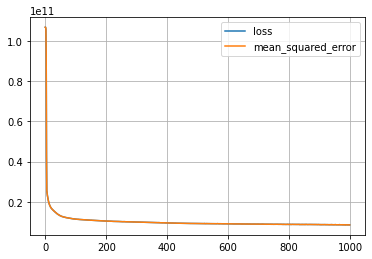

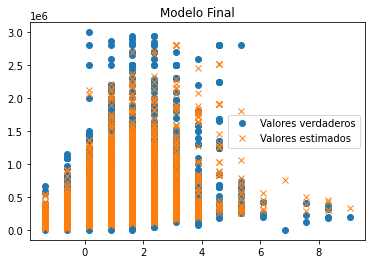

850/850 [==============================] - 1s 2ms/step


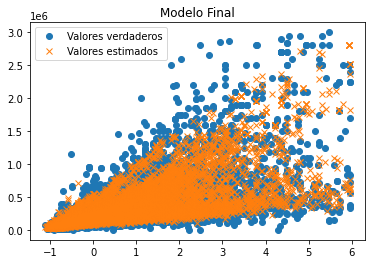

850/850 [==============================] - 1s 893us/step


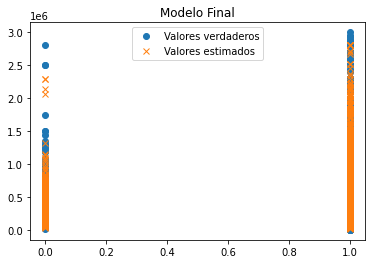

850/850 [==============================] - 1s 850us/step


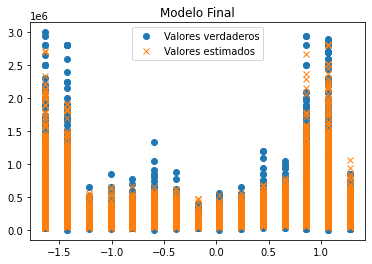

In [ ]:
hist = pd.DataFrame(modelo_1_historia.history)
hist['epoch'] = modelo_1_historia.epoch
hist.tail()
plot_loss(modelo_1_historia)

plot_regression(model_1,x_test_redes,y_test,title=f"Modelo Final",xlabel="sup total",ylabel="price")

##Clasificacion

In [ ]:
columnas = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud', 'property_type_Departamento',
            'property_type_PH']
            
x_train_target = train_con_dummi[columnas]
x_test_target = test_con_dummi[columnas]

In [ ]:
import warnings

def escalar_variable(palabra, ds_train =x_train_target, ds_test = x_test_target):
  warnings.filterwarnings('ignore')
  
  sscaler=StandardScaler()

  sscaler.fit(pd.DataFrame(ds_train[[palabra]]))

  ds_train_transform = sscaler.transform(pd.DataFrame(ds_train[palabra]))
  ds_test_transform = sscaler.transform(pd.DataFrame(ds_test[palabra]))

  ds_train[palabra] = ds_train_transform[:,0]
  ds_test[palabra] = ds_test_transform[:,0]
  return ds_train, ds_test

In [ ]:
x_train_target, x_test_target = escalar_variable('property_surface_total')
x_train_target, x_test_target = escalar_variable('property_surface_covered')
x_train_target, x_test_target = escalar_variable('latitud')
x_train_target, x_test_target = escalar_variable('longitud')
x_train_target, x_test_target = escalar_variable('property_rooms')
x_train_target, x_test_target = escalar_variable('property_bedrooms')

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(30, activation='relu', input_dim=8))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(17, activation='relu'))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(11, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', #adadelta el mas rapido
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 30)                270       
                                                                 
 dense_9 (Dense)             (None, 24)                744       
                                                                 
 dense_10 (Dense)            (None, 17)                425       
                                                                 
 dense_11 (Dense)            (None, 12)                216       
                                                                 
 dense_12 (Dense)            (None, 11)                143       
                                                                 
 dense_13 (Dense)            (None, 8)                 96        
                                                                 
 dense_14 (Dense)            (None, 6)                

In [ ]:
y_train_target = pd.get_dummies(y_train_target, columns=["tipo_precio_generico"], drop_first=False)

In [ ]:
historia_model=model.fit(x_train_target,y_train_target,epochs=90,batch_size=5000,verbose=False, validation_split=0.33)

In [ ]:
historia_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

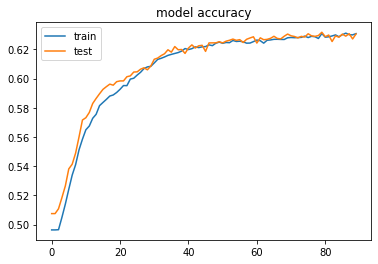

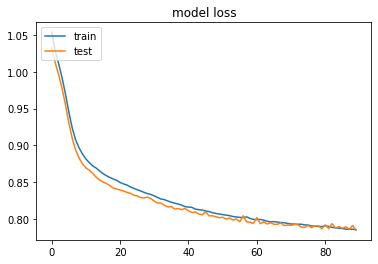

In [ ]:
# summarize history for accuracy
plt.plot(historia_model.history['accuracy'])
plt.plot(historia_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel = "accuracy"
plt.xlabel = "epoch"
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historia_model.history['loss'])
plt.plot(historia_model.history['val_loss'])
plt.title('model loss')
plt.ylabel = "loss"
plt.xlabel = "epoch"
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_predic = model.predict(x_test_target)

850/850 [==============================] - 1s 814us/step


In [ ]:
y_predic_clases=np.argmax(y_predic,axis=1).tolist()

In [ ]:
y_test_target.replace(to_replace=['high_price','low_price', 'medium_price'],value=[0,1,2],inplace=True)

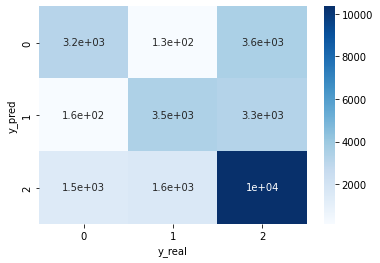

In [ ]:
ds_validation=pd.DataFrame(y_predic_clases,y_test_target).reset_index()
ds_validation.columns=['y_pred','y_real']

tabla_iris=pd.crosstab(ds_validation.y_pred, ds_validation.y_real)
grf=sns.heatmap(tabla_iris,annot=True, cmap = 'Blues')
plt.show()

#Ensambles

In [ ]:
columnas_viejas = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud',
                   'property_type_Departamento','property_type_PH']

columnas = ['property_rooms', 'property_bedrooms', 'property_surface_total','property_surface_covered', 'latitud', 'longitud', 'property_type_Departamento',
            'property_type_PH', 'amenities', 'piso', 'comuna', 'tiene_patio_o_balcon', 'esta_cerca_de_av']
            
x_train_target = train_con_dummi[columnas]
x_test_target = test_con_dummi[columnas]

x_train_target_viejo = train_con_dummi[columnas_viejas]
x_test_target_viejo  = test_con_dummi[columnas_viejas]

In [ ]:
y_train_target = train_con_dummi['tipo_precio_generico'].copy()
y_test_target = test_con_dummi['tipo_precio_generico'].copy()

In [ ]:
import collections
def identificar_clasificacion(y_pred, tabla):
  counts = collections.Counter(y_pred)
  
  claves = list(counts.keys())
  claves[0]

  clase_0 = tabla[0][0]+tabla[1][0]+tabla[2][0]
  clase_1 = tabla[0][1]+tabla[1][1]+tabla[2][1]
  clase_2 = tabla[0][2]+tabla[1][2]+tabla[2][2]

  lista = ['a', 'b', 'c']

  for i in range(len(claves)):  
    if(counts[claves[i]] == clase_0):
      lista[0] = claves[i]
    elif(counts[claves[i]] == clase_1):
      lista[1] = claves[i]
    else:
      lista[2] = claves[i]

  return lista

##Voting


###Dataset con features nuevos

In [ ]:
#Clasificador
dt = DecisionTreeClassifier()

#Metrica
dt_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_randomcv = cross_validation_function(x_train_target, y_train_target, base_tree=dt, scorer_fn=dt_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
dt=DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Clasificador
rmf = RandomForestClassifier()

#Metrica
rmf_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_randomcv = cross_validation_function(x_train_target, y_train_target,  base_tree=rmf, scorer_fn=rmf_scorer_fn)

#Creo el árbol con los mejores hiperparámetros
rmf=RandomForestClassifier(random_state=2).set_params(**rmf_randomcv.best_params_)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#Clasificador
ab = AdaBoostClassifier()

# Metrica
ab_scorer_fn = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_params_grid = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_randomcv = cross_validation_function(x_train_target, y_train_target, base_tree=ab, scorer_fn=ab_scorer_fn, params_grid=ab_params_grid)

ab=AdaBoostClassifier(random_state=2).set_params(**ab_randomcv.best_params_)

In [ ]:
from sklearn.ensemble import  VotingClassifier
vot_clf = VotingClassifier(estimators = [('randomforest', rmf), ('dtree', dt), ('adaboost', ab)], voting = 'soft')

In [ ]:
vot_clf

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('dtree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=84,
                                                 random_state=2))],
                 voting='soft')

In [ ]:
#Entreno el ensemble
vot_clf.fit(x_train_target, y_train_target)

#Evaluo en conjunto de test
y_pred_vot = vot_clf.predict(x_test_target)

In [ ]:
# Evalúo en el set de test
vot_accuracy=accuracy_score(y_test_target,y_pred_vot)
vot_recall=recall_score(y_test_target,y_pred_vot, average='macro')
vot_f1=f1_score(y_test_target,y_pred_vot, average='macro')

print("Accuracy: "+str(vot_accuracy))
print("Recall: "+str(vot_recall))
print("f1 score: "+str(vot_f1))

Accuracy: 0.6019499632082413
Recall: 0.5393577127483185
f1 score: 0.5594065070835804


[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

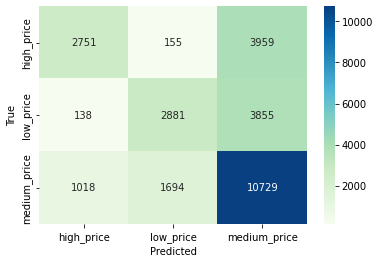

In [ ]:
#Creo la matriz de confusión
vot_tabla=confusion_matrix(y_test_target, y_pred_vot)

vot_columnas=identificar_clasificacion(y_pred_vot,vot_tabla)

#Grafico la matriz de confusión
sns.heatmap(vot_tabla,cmap='GnBu',annot=True,fmt='g', yticklabels = vot_columnas, xticklabels = vot_columnas).set(xlabel="Predicted", ylabel="True")

###Dataset con features TP1

In [ ]:
#Clasificador
dt_viejo = DecisionTreeClassifier()

#Metrica
dt_scorer_fn_viejo = make_scorer(sk.metrics.f1_score, average = 'macro')

dt_randomcv_viejo = cross_validation_function(x_train_target_viejo, y_train_target, base_tree=dt_viejo, scorer_fn=dt_scorer_fn_viejo)

#Creo el árbol con los mejores hiperparámetros
dt_viejo=DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv_viejo.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Clasificador
rmf_viejo = RandomForestClassifier()

#Metrica
rmf_scorer_fn_viejo = make_scorer(sk.metrics.f1_score, average = 'macro') 

rmf_randomcv_viejo = cross_validation_function(x_train_target_viejo, y_train_target,  base_tree=rmf_viejo, scorer_fn=rmf_scorer_fn_viejo)

#Creo el árbol con los mejores hiperparámetros
rmf_viejo=RandomForestClassifier(random_state=2).set_params(**rmf_randomcv_viejo.best_params_)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#Clasificador
ab_viejo = AdaBoostClassifier()

# Metrica
ab_scorer_fn_viejo = make_scorer(sk.metrics.f1_score, average = 'macro')

ab_params_grid = {'learning_rate':np.linspace(0.01,0.1,10),
               'n_estimators': list(range(1,100))}

ab_randomcv_viejo = cross_validation_function(x_train_target_viejo, y_train_target, base_tree=ab_viejo, scorer_fn=ab_scorer_fn_viejo, params_grid=ab_params_grid)

ab_viejo=AdaBoostClassifier(random_state=2).set_params(**ab_randomcv_viejo.best_params_)

In [ ]:
from sklearn.ensemble import  VotingClassifier
vot_clf_viejo = VotingClassifier(estimators = [('randomforest', rmf_viejo), ('dtree', dt_viejo), ('adaboost', ab_viejo)], voting= 'soft')

In [ ]:
vot_clf_viejo

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('dtree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=2)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=84,
                                                 random_state=2))],
                 voting='soft')

In [ ]:
#Entreno el ensemble
vot_clf_viejo.fit(x_train_target_viejo, y_train_target)

#Evaluo en conjunto de test
y_pred_vot = vot_clf_viejo.predict(x_test_target_viejo)

In [ ]:
# Evalúo en el set de test
vot_accuracy_viejo=accuracy_score(y_test_target,y_pred_vot)
vot_recall_viejo=recall_score(y_test_target,y_pred_vot, average='macro')
vot_f1_viejo=f1_score(y_test_target,y_pred_vot, average='macro')

print("Accuracy: "+str(vot_accuracy_viejo))
print("Recall: "+str(vot_recall_viejo))
print("f1 score: "+str(vot_f1_viejo))

Accuracy: 0.5838852097130243
Recall: 0.5065272837896727
f1 score: 0.522733325552808


[Text(32.09375, 0.5, 'True'), Text(0.5, 14.09375, 'Predicted')]

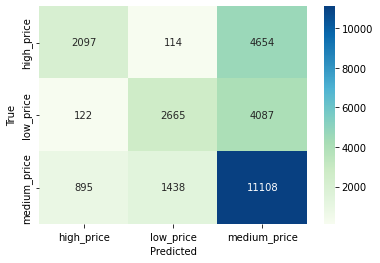

In [ ]:
#Creo la matriz de confusión
vot_tabla_viejo=confusion_matrix(y_test_target, y_pred_vot)

vot_columnas_viejo=identificar_clasificacion(y_pred_vot,vot_tabla)

#Grafico la matriz de confusión
sns.heatmap(vot_tabla_viejo,cmap='GnBu',annot=True,fmt='g', yticklabels = vot_columnas, xticklabels = vot_columnas).set(xlabel="Predicted", ylabel="True")

##Stacking

###Dataset con features nuevos

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import defaultdict

import plotly.graph_objects as go
%matplotlib inline

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [ ]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(random_state=2).set_params(**rmf_randomcv.best_params_),
               'adaBoost': AdaBoostClassifier(random_state=2).set_params(**ab_randomcv.best_params_),
               'DecisionTree': DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv.best_params_)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_target, y_train_target)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   50.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating adaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating DecisionTree


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished


In [ ]:
from sklearn.ensemble import StackingClassifier

# #Modelos Base
base_models = [('random_forest',RandomForestClassifier(random_state=2).set_params(**rmf_randomcv.best_params_)),
               ('adaBoost', AdaBoostClassifier(random_state=2).set_params(**ab_randomcv.best_params_)),
               ('DecisionTree', DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv.best_params_))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train_target, y_train_target)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 21.2min finished


In [ ]:
model_scores

defaultdict(None,
            {'random_forest': array([0.61306612, 0.61732681, 0.60624951, 0.60727531, 0.61477156,
                    0.61054127, 0.61551207, 0.61090507, 0.61208869, 0.60640732]),
             'adaBoost': array([0.55688812, 0.56312135, 0.55874694, 0.55851022, 0.5573266 ,
                    0.55783494, 0.5656462 , 0.5613509 , 0.55606407, 0.55401247]),
             'DecisionTree': array([0.59578665, 0.60612277, 0.59891107, 0.60482916, 0.60901128,
                    0.59673347, 0.61133028, 0.58991557, 0.60261974, 0.59906889]),
             'stacking': array([0.62261322, 0.62931987, 0.62282017, 0.63789158, 0.63086878,
                    0.62939877, 0.63208143, 0.63063205, 0.62621321, 0.62211   ])})

In [ ]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

In [ ]:
#Evaluo en conjunto de test
stacking_model.fit(x_train_target,y_train_target).score(x_test_target,y_test_target)
y_pred_st = stacking_model.predict(x_test_target)
accuracy_score(y_test_target, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


0.6255334805003679

###Dataset con features TP1

In [ ]:
#Modelos Base
base_models_viejo = {'random_forest':RandomForestClassifier(random_state=2).set_params(**rmf_randomcv_viejo.best_params_),
               'adaBoost': AdaBoostClassifier(random_state=2).set_params(**ab_randomcv_viejo.best_params_),
               'DecisionTree': DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv_viejo.best_params_)}

#Guarda los scores de cada modelo
model_scores_viejo = defaultdict()

#Entreno los clasificadores
for name, model in base_models_viejo.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_target_viejo, y_train_target)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   41.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating adaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating DecisionTree


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished


In [ ]:
from sklearn.ensemble import StackingClassifier

# #Modelos Base
base_models_viejo = [('random_forest',RandomForestClassifier(random_state=2).set_params(**rmf_randomcv_viejo.best_params_)),
               ('adaBoost', AdaBoostClassifier(random_state=2).set_params(**ab_randomcv_viejo.best_params_)),
               ('DecisionTree', DecisionTreeClassifier(random_state=2).set_params(**dt_randomcv_viejo.best_params_))]

#Meta Modelo
meta_model_viejo = LogisticRegressionCV()

#Ensemble Stacking
stacking_model_viejo = StackingClassifier(estimators=base_models_viejo, 
                                    final_estimator=meta_model_viejo, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
stacking_scores_viejo = evaluate_model(stacking_model_viejo, x_train_target_viejo, y_train_target)
model_scores_viejo['stacking'] = stacking_scores_viejo

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 17.7min finished


In [ ]:
model_scores_viejo

defaultdict(None,
            {'stacking': array([0.60557046, 0.62316554, 0.60569715, 0.61082617, 0.61051053,
                    0.60123087, 0.62032507, 0.60372445, 0.61382467, 0.61271996])})

In [ ]:
#Grafico performance
plot_results(model_scores_viejo, name='stacking_model_cv')

In [ ]:
#Evaluo en conjunto de test
stacking_model_viejo.fit(x_train_target_viejo,y_train_target).score(x_test_target_viejo,y_test_target)
y_pred_st = stacking_model_viejo.predict(x_test_target_viejo)
accuracy_score(y_test_target, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


0.6122516556291391